In [1]:
import os
import seaborn as sns
import numpy as np
from graph_class import *
from nltk_class import *

In [2]:
with open('twitter.json', 'r') as file:
    tweet = pd.DataFrame(json.load(file))

nlp = NltkTextProcessing()
tweet_df = nlp.add_processed_column(tweet, save=False)
unique_df = nlp.keep_unique(tweet_df)
unique_df.head(1)

,created_at,id,tweet_text,is_reply,reply_count,retweet_count,hashtags,external_url,author_followers,author_follow,author_loc,media_text
0,2021-08-21 10:22:57,1429026229592764417,"[oltre, milioni, ebrei, militari, rom, omosess...",False,0,0,None,https://twitter.com/i/web/status/1429026229592...,527,951,Roma,None


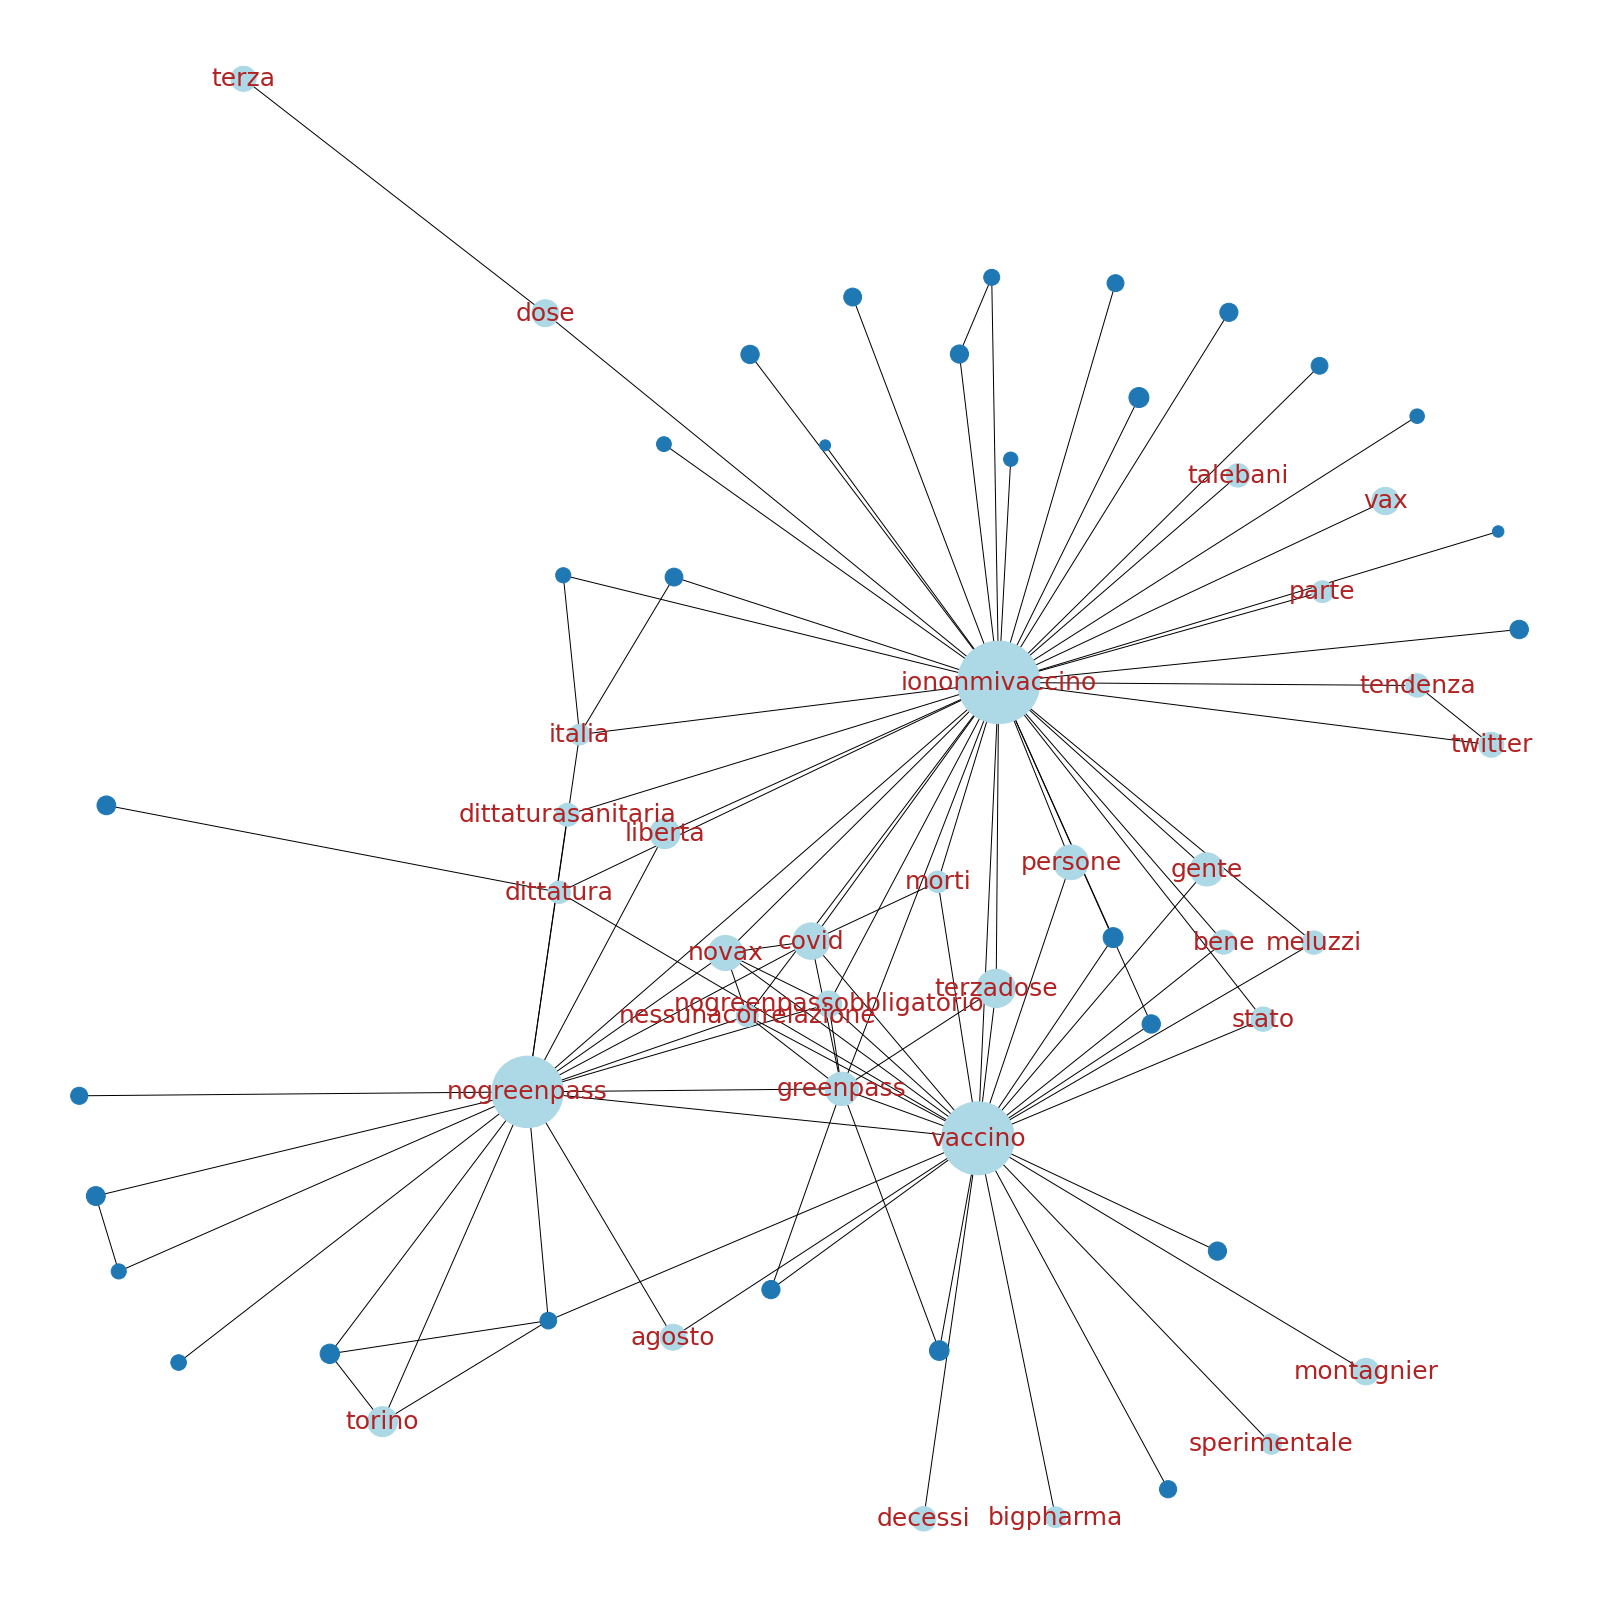

In [3]:
freq_distrib_tweet = nlp.frequency_dist(tweet_df, obj ='tweet')
graph_tweet = filter_pairwise_words(graph_filtered_dist(df=unique_df, distrib=freq_distrib_tweet, thresold=200), thresold=40)
NetworkPlot(graph=graph_tweet, frequency_dist=freq_distrib_tweet, label_thresold=400, color_thresold=400).plot()

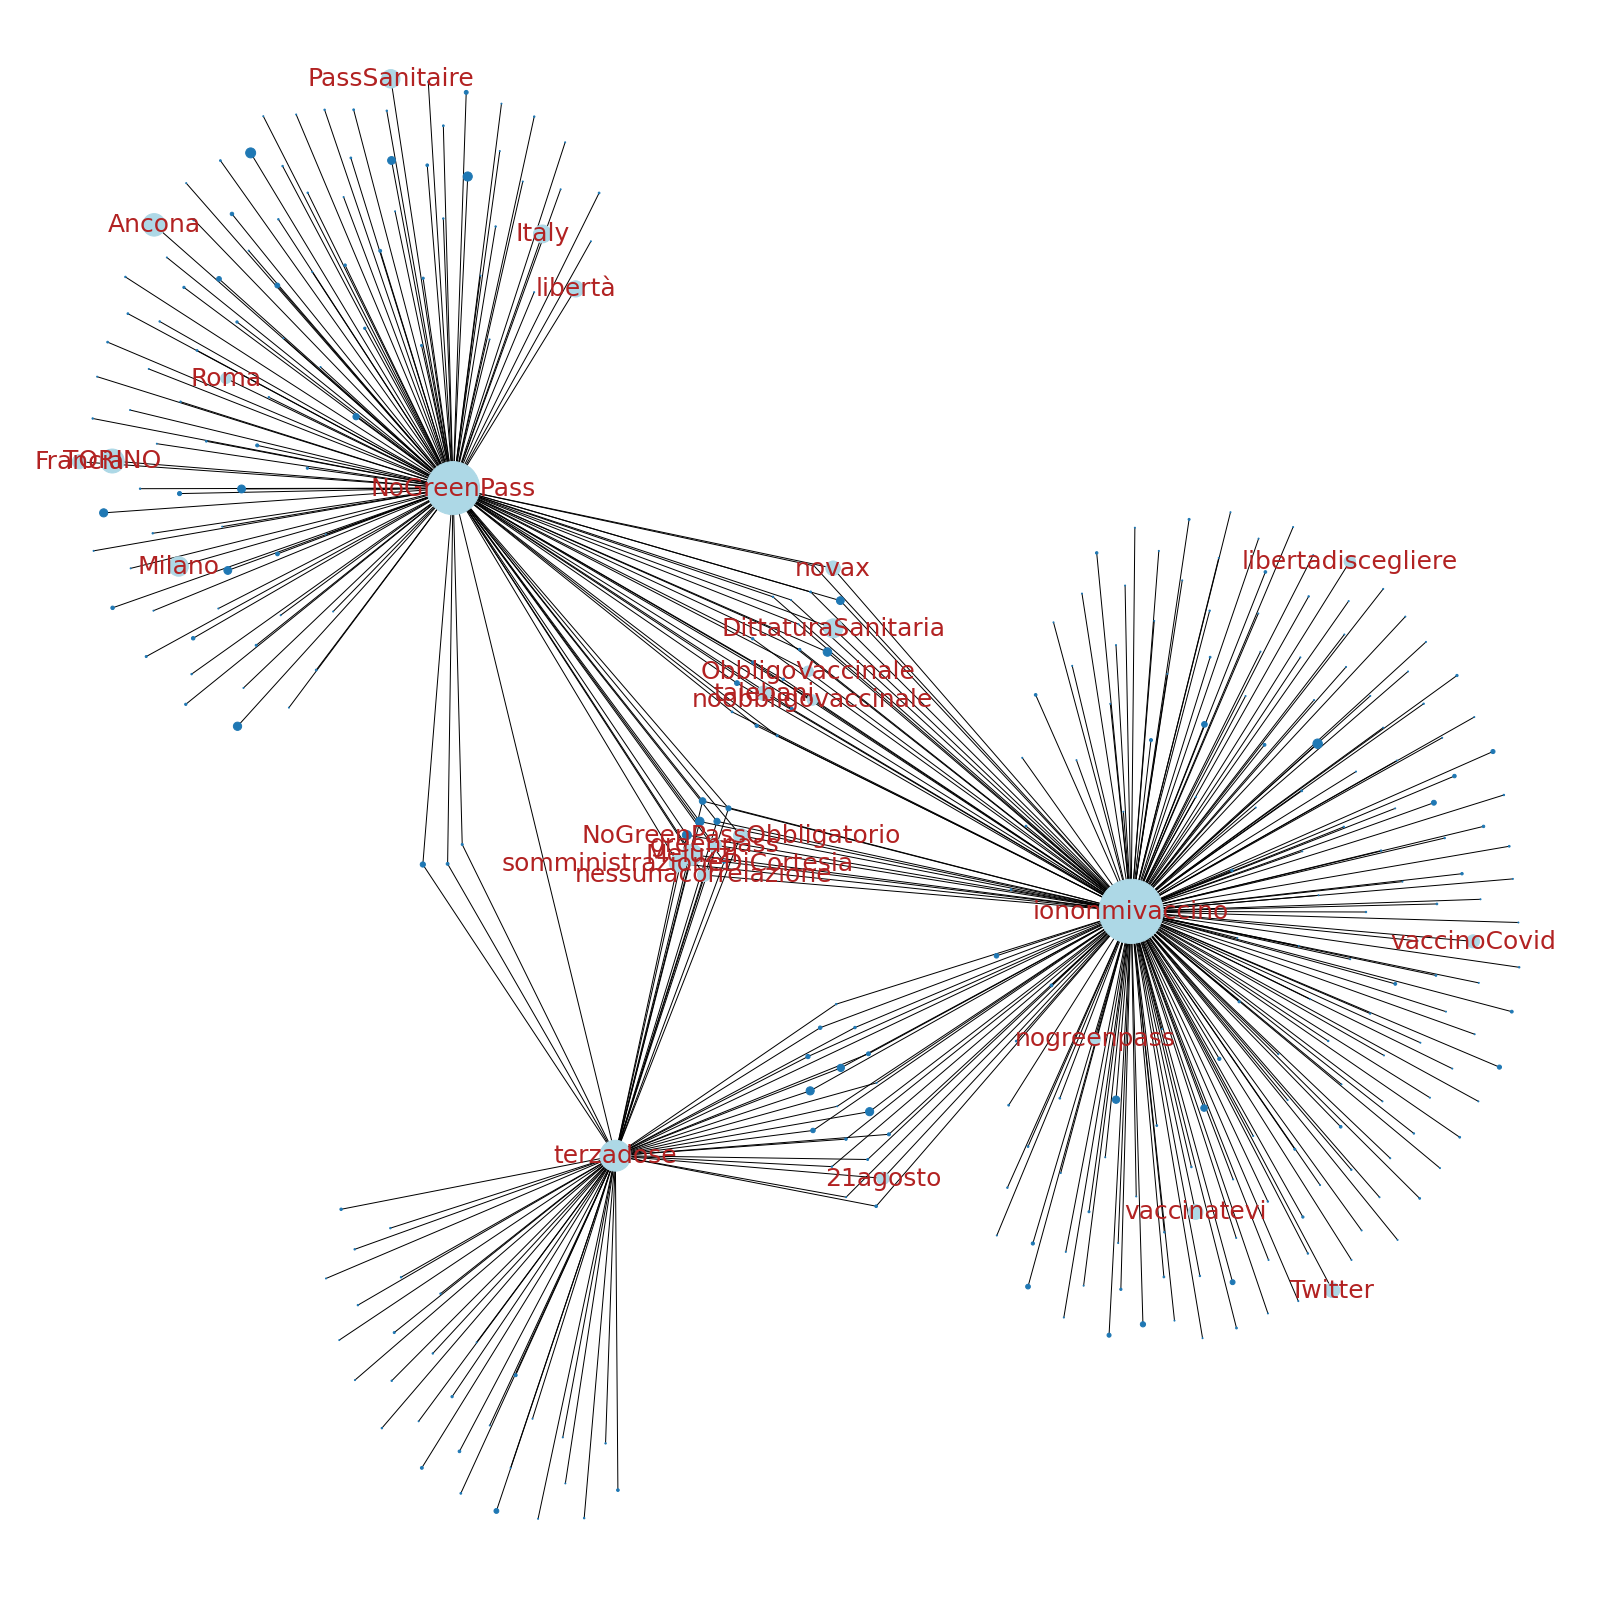

In [7]:
freq_distrib_hash = nlp.frequency_dist(tweet_df, obj ='hash')
graph_hash = graph_filtered_dist(df=unique_df, distrib=freq_distrib_hash, thresold=600, obj='hash')
NetworkPlot(graph= graph_hash, frequency_dist=freq_distrib_hash, label_thresold=100, color_thresold=100).plot()